In [1]:
# tf tools
import tensorflow as tf


# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt

#rest
import json
import numpy
import pandas as pd
import random

2023-05-09 13:22:06.393894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

#sample
def make_dataframe_from_json(json_path, num_samples=None):
    # Load JSON data into a list of dictionaries
    data = []
    with open(json_path) as f:
        for line in f:
            data.append(json.loads(line))

    # Randomly sample num_samples if specified
    if num_samples is not None:
        data = random.sample(data, num_samples)

    # Convert list of dictionaries to a dataframe
    return pd.DataFrame(data)

train_df = make_dataframe_from_json("/work/cds-viz/vis-data/indo_fashion/train_data.json", num_samples=20000)
val_df = make_dataframe_from_json("/work/cds-viz/vis-data/indo_fashion/val_data.json", num_samples=7500)
test_df = make_dataframe_from_json("/work/cds-viz/vis-data/indo_fashion/test_data.json", num_samples=7500)

NUMBER_OF_CLASSES = train_df["class_label"].nunique()




/tmp/ipykernel_4017/4229246552.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(label_counts.index, rotation=45)


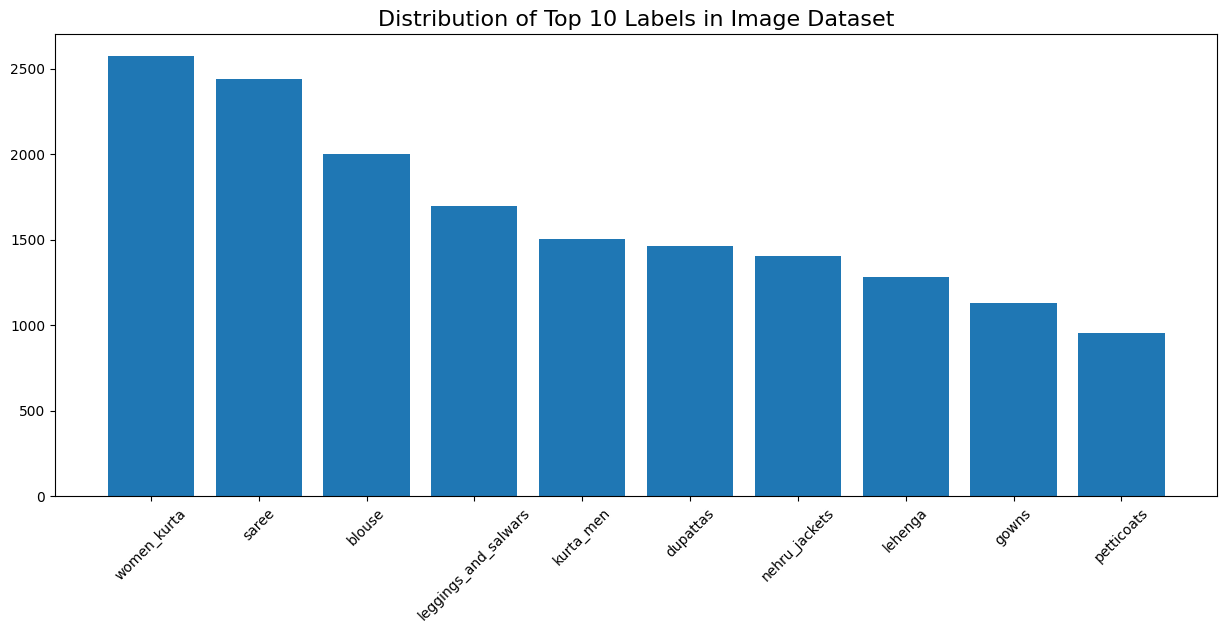

In [3]:
# testing to see we now have working labels
label_counts = train_df["class_label"].value_counts()[:10]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
axes.bar(label_counts.index, label_counts.values)
axes.set_title('Distribution of Top 10 Labels in Image Dataset', fontsize=16)
axes.set_xticklabels(label_counts.index, rotation=45)
# Display the plot
plt.show()

In [4]:

#Load VGG16
model = VGG16(weights='imagenet', 
              include_top=False,
              pooling='avg',
              input_shape=(224, 224, 3))

#Freeze the base model layers so only the layers we add on top will be trainable
for layer in model.layers:
    layer.trainable = False

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:


# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu')(flat1)
output = Dense(15, activation='softmax')(class1)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
#Compile the model. Have to set a learning rate as we are working with the SGD optimizer instead of the ADAM one. 
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="class_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="class_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="class_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')


Found 20000 validated image filenames belonging to 15 classes.
Found 7500 validated image filenames belonging to 15 classes.
Found 7500 validated image filenames belonging to 15 classes.


In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)




Epoch 1/10


2023-05-09 13:22:30.215833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - ETA: 0s - loss: 2.3451 - accuracy: 0.2886

2023-05-09 13:49:30.325420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 2213s 4s/step - loss: 2.3451 - accuracy: 0.2886 - val_loss: 2.3120 - val_accuracy: 0.2327
Epoch 2/10
625/625 [==============================] - 2644s 4s/step - loss: 1.8923 - accuracy: 0.4166 - val_loss: 1.8287 - val_accuracy: 0.4051
Epoch 3/10
625/625 [==============================] - 2688s 4s/step - loss: 1.6052 - accuracy: 0.5060 - val_loss: 1.5653 - val_accuracy: 0.4757
Epoch 4/10
625/625 [==============================] - 2579s 4s/step - loss: 1.4342 - accuracy: 0.5594 - val_loss: 1.4352 - val_accuracy: 0.5335
Epoch 5/10
625/625 [==============================] - 2406s 4s/step - loss: 1.3256 - accuracy: 0.5883 - val_loss: 1.3125 - val_accuracy: 0.5663
Epoch 6/10
625/625 [==============================] - 2248s 4s/step - loss: 1.2469 - accuracy: 0.6097 - val_loss: 1.2566 - val_accuracy: 0.5807
Epoch 7/10
625/625 [==============================] - 2292s 4s/step - loss: 1.1891 - accuracy: 0.6260 - val_loss: 1.1929 - val_accuracy: 0.5920
Epo

In [9]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))

2023-05-09 20:00:06.514231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - 521s 2s/step - loss: 1.0753 - accuracy: 0.6460


In [10]:
# Save the model
model.save('model.h5')

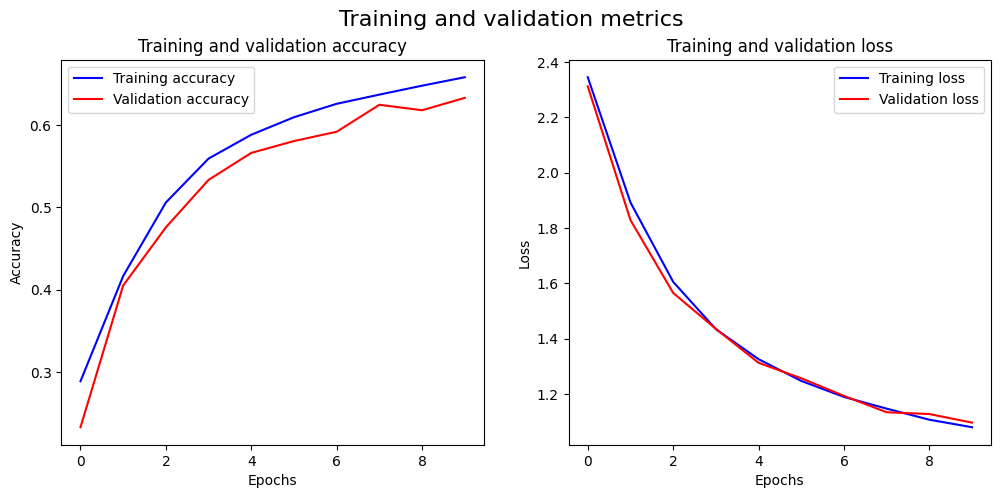

In [11]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.savefig('history_plots.png')
plt.show()


In [12]:
#prediction and classifcation report
pred = model.predict(test_generator)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]



2023-05-09 20:11:00.754716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - 505s 2s/step


In [13]:
y_test = list(test_df.class_label)
print(classification_report(y_test, pred))

report = classification_report(y_test, pred)
with open('classification_report.txt', 'w') as f:
    f.write(report)

                      precision    recall  f1-score   support

              blouse       0.05      0.06      0.05       500
         dhoti_pants       0.09      0.02      0.04       500
            dupattas       0.07      0.04      0.05       500
               gowns       0.08      0.03      0.04       500
           kurta_men       0.07      0.08      0.07       500
leggings_and_salwars       0.06      0.09      0.07       500
             lehenga       0.05      0.05      0.05       500
         mojaris_men       0.05      0.05      0.05       500
       mojaris_women       0.06      0.06      0.06       500
       nehru_jackets       0.05      0.04      0.05       500
            palazzos       0.06      0.04      0.05       500
          petticoats       0.07      0.06      0.06       500
               saree       0.07      0.11      0.09       500
           sherwanis       0.07      0.04      0.05       500
         women_kurta       0.05      0.13      0.08       500

      